In [1]:
import os
from pyexpat import model
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import RocCurveDisplay
import numpy as np
from sklearn.metrics import classification_report
# dataset path
data_dir = r"C:\Users\sahba\Downloads\archive (2)\IMG_CLASSES"

# augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),

    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# loading the dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)


print("Classes:", full_dataset.classes)

from torch.utils.data import random_split, DataLoader

# calculating sizes for train, val, and test (70%, 15%, 15%)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size 

# spliting the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Classes: ['C', 'M', 'MN', 'R', 'SK', 'WM']


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(0)) 

# loading ResNet-50 model
model = models.resnet50(pretrained=True)

# freezing all layers
for param in model.parameters():
     param.requires_grad = False
     # unfreezing the last two convolutional blocks
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.layer3.parameters():
    param.requires_grad = True



# replacing the final fully connected layer for 6-class classification
num_classes = 6

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(512, num_classes),
)


model = model.to(device)

Using device: cuda
NVIDIA GeForce RTX 4060 Laptop GPU


c:\Users\sahba\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sahba\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# number of samples per class
class_counts = [
    2697,    # Melanoma
    2215,    # Carcinoma
    6946,    # Melanocytic_Nevi
    1827,    # Seborrheic_Keratoses
    1644,    # TineaRingwormCandidiasis
    1888     # WartsMolluscum
]

# converting to tensor and compute weights
class_counts_tensor = torch.tensor(class_counts, dtype=torch.float)
class_weights = 1.0 / class_counts_tensor
class_weights = class_weights / class_weights.sum() * len(class_counts)  # normalization to match number of classes
class_weights = class_weights.to(device) 
print("Class weights:", class_weights)

Class weights: tensor([0.8390, 1.0216, 0.3258, 1.2386, 1.3764, 1.1986], device='cuda:0')


c:\Users\sahba\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch [1/75]


Train Loss: 1.1366, Train Acc: 68.35%
Val Loss: 0.9250, Val Acc: 79.29%

Epoch [2/75]


Train Loss: 0.9510, Train Acc: 80.58%
Val Loss: 0.8773, Val Acc: 86.58%

Epoch [3/75]


Train Loss: 0.9050, Train Acc: 83.52%
Val Loss: 0.8193, Val Acc: 87.67%

Epoch [4/75]


Train Loss: 0.8518, Train Acc: 86.13%
Val Loss: 0.8139, Val Acc: 88.41%

Epoch [5/75]


Train Loss: 0.8200, Train Acc: 87.85%
Val Loss: 0.7857, Val Acc: 89.80%

Epoch [6/75]


Train Loss: 0.7906, Train Acc: 89.29%
Val Loss: 0.7835, Val Acc: 87.36%

Epoch [7/75]


Train Loss: 0.7752, Train Acc: 89.77%
Val Loss: 0.7785, Val Acc: 90.69%

Epoch [8/75]


Train Loss: 0.7364, Train Acc: 91.61%
Val Loss: 0.7661, Val Acc: 89.69%

Epoch [9/75]


Train Loss: 0.7238, Train Acc: 92.42%
Val Loss: 0.7603, Val Acc: 91.55%

Epoch [10/75]


Train Loss: 0.7179, Train Acc: 92.65%
Val Loss: 0.7789, Val Acc: 90.73%

Epoch [11/75]


Train Loss: 0.7038, Train Acc: 93.09%
Val Loss: 0.7479, Val Acc: 91.51%

Epoch [12/75]


Train Loss: 0.6776, Train Acc: 94.06%
Val Loss: 0.7588, Val Acc: 91.66%

Epoch [13/75]


Train Loss: 0.6671, Train Acc: 94.60%
Val Loss: 0.7391, Val Acc: 91.43%

Epoch [14/75]


Train Loss: 0.6604, Train Acc: 95.14%
Val Loss: 0.7600, Val Acc: 91.86%

Epoch [15/75]


Train Loss: 0.6457, Train Acc: 95.65%
Val Loss: 0.7515, Val Acc: 91.78%

Epoch [16/75]


Train Loss: 0.6430, Train Acc: 95.83%
Val Loss: 0.7338, Val Acc: 91.78%

Epoch [17/75]


Train Loss: 0.6306, Train Acc: 96.23%
Val Loss: 0.7594, Val Acc: 91.74%

Epoch [18/75]


Train Loss: 0.6272, Train Acc: 96.38%
Val Loss: 0.7510, Val Acc: 92.28%

Epoch [19/75]


Train Loss: 0.6210, Train Acc: 96.59%
Val Loss: 0.7401, Val Acc: 91.93%

Epoch [20/75]


Train Loss: 0.6194, Train Acc: 96.46%
Val Loss: 0.7629, Val Acc: 92.59%

Epoch [21/75]


Train Loss: 0.5977, Train Acc: 97.40%
Val Loss: 0.7357, Val Acc: 92.67%

Epoch [22/75]


Train Loss: 0.5908, Train Acc: 97.67%
Val Loss: 0.7343, Val Acc: 92.17%

Epoch [23/75]


Train Loss: 0.5922, Train Acc: 97.54%
Val Loss: 0.7139, Val Acc: 93.29%

Epoch [24/75]


Train Loss: 0.5944, Train Acc: 97.37%
Val Loss: 0.7236, Val Acc: 92.83%

Epoch [25/75]


Train Loss: 0.5915, Train Acc: 97.46%
Val Loss: 0.7214, Val Acc: 93.14%

Epoch [26/75]


Train Loss: 0.5868, Train Acc: 97.84%
Val Loss: 0.7035, Val Acc: 93.21%

Epoch [27/75]


Train Loss: 0.5863, Train Acc: 97.91%
Val Loss: 0.7090, Val Acc: 93.21%

Epoch [28/75]


Train Loss: 0.5831, Train Acc: 97.97%
Val Loss: 0.7284, Val Acc: 92.87%

Epoch [29/75]


Train Loss: 0.5788, Train Acc: 98.06%
Val Loss: 0.7253, Val Acc: 93.14%

Epoch [30/75]


Train Loss: 0.5781, Train Acc: 97.96%
Val Loss: 0.7006, Val Acc: 93.83%

Epoch [31/75]


Train Loss: 0.5762, Train Acc: 98.23%
Val Loss: 0.7016, Val Acc: 93.41%

Epoch [32/75]


Train Loss: 0.5776, Train Acc: 98.06%
Val Loss: 0.7292, Val Acc: 93.02%

Epoch [33/75]


Train Loss: 0.5788, Train Acc: 98.01%
Val Loss: 0.7059, Val Acc: 93.29%

Epoch [34/75]


Train Loss: 0.5780, Train Acc: 98.19%
Val Loss: 0.7175, Val Acc: 93.41%

Epoch [35/75]


Train Loss: 0.5655, Train Acc: 98.65%
Val Loss: 0.7045, Val Acc: 93.33%

Epoch [36/75]


Train Loss: 0.5723, Train Acc: 98.32%
Val Loss: 0.6927, Val Acc: 93.45%

Epoch [37/75]


Train Loss: 0.5669, Train Acc: 98.60%
Val Loss: 0.7045, Val Acc: 93.14%

Epoch [38/75]


Train Loss: 0.5683, Train Acc: 98.43%
Val Loss: 0.7051, Val Acc: 93.83%

Epoch [39/75]


Train Loss: 0.5638, Train Acc: 98.65%
Val Loss: 0.7157, Val Acc: 92.83%

Epoch [40/75]


Train Loss: 0.5639, Train Acc: 98.50%
Val Loss: 0.7092, Val Acc: 93.52%

Epoch [41/75]


Train Loss: 0.5649, Train Acc: 98.60%
Val Loss: 0.7099, Val Acc: 93.18%

Epoch [42/75]


Train Loss: 0.5616, Train Acc: 98.71%
Val Loss: 0.6997, Val Acc: 93.80%

Epoch [43/75]


Train Loss: 0.5610, Train Acc: 98.66%
Val Loss: 0.7029, Val Acc: 93.52%

Epoch [44/75]


Train Loss: 0.5587, Train Acc: 98.87%
Val Loss: 0.7026, Val Acc: 93.18%

Epoch [45/75]


Train Loss: 0.5579, Train Acc: 98.74%
Val Loss: 0.7070, Val Acc: 93.25%

Epoch [46/75]


Train Loss: 0.5571, Train Acc: 98.84%
Val Loss: 0.7046, Val Acc: 93.64%

Epoch [47/75]


Train Loss: 0.5581, Train Acc: 98.77%
Val Loss: 0.7196, Val Acc: 92.87%

Epoch [48/75]


Train Loss: 0.5578, Train Acc: 98.85%
Val Loss: 0.6984, Val Acc: 93.29%

Epoch [49/75]


Train Loss: 0.5575, Train Acc: 98.78%
Val Loss: 0.7208, Val Acc: 93.06%

Epoch [50/75]


Train Loss: 0.5598, Train Acc: 98.82%
Val Loss: 0.7122, Val Acc: 92.90%

Epoch [51/75]


Train Loss: 0.5579, Train Acc: 98.85%
Val Loss: 0.7052, Val Acc: 93.64%

Epoch [52/75]


Train Loss: 0.5563, Train Acc: 98.90%
Val Loss: 0.7065, Val Acc: 93.18%

Epoch [53/75]


Train Loss: 0.5580, Train Acc: 98.83%
Val Loss: 0.7135, Val Acc: 93.72%

Epoch [54/75]


Train Loss: 0.5565, Train Acc: 98.94%
Val Loss: 0.7054, Val Acc: 93.18%

Epoch [55/75]


Train Loss: 0.5560, Train Acc: 98.89%
Val Loss: 0.6955, Val Acc: 93.68%

Epoch [56/75]


Train Loss: 0.5576, Train Acc: 98.71%
Val Loss: 0.6892, Val Acc: 94.03%

Epoch [57/75]


Train Loss: 0.5557, Train Acc: 98.72%
Val Loss: 0.7071, Val Acc: 93.91%

Epoch [58/75]


Train Loss: 0.5559, Train Acc: 98.80%
Val Loss: 0.7081, Val Acc: 93.33%

Epoch [59/75]


Train Loss: 0.5557, Train Acc: 98.86%
Val Loss: 0.7049, Val Acc: 93.52%

Epoch [60/75]


Train Loss: 0.5566, Train Acc: 98.89%
Val Loss: 0.6947, Val Acc: 93.56%

Epoch [61/75]


Train Loss: 0.5543, Train Acc: 98.84%
Val Loss: 0.7057, Val Acc: 93.10%

Epoch [62/75]


Train Loss: 0.5539, Train Acc: 98.88%
Val Loss: 0.7024, Val Acc: 93.60%

Epoch [63/75]


Train Loss: 0.5552, Train Acc: 98.86%
Val Loss: 0.6901, Val Acc: 93.56%

Epoch [64/75]


Train Loss: 0.5546, Train Acc: 98.84%
Val Loss: 0.6996, Val Acc: 93.60%

Epoch [65/75]


Train Loss: 0.5536, Train Acc: 98.93%
Val Loss: 0.7037, Val Acc: 92.48%

Epoch [66/75]


Train Loss: 0.5540, Train Acc: 98.90%
Val Loss: 0.7040, Val Acc: 93.33%

Epoch [67/75]


Train Loss: 0.5559, Train Acc: 98.72%
Val Loss: 0.6943, Val Acc: 93.76%

Epoch [68/75]


Train Loss: 0.5591, Train Acc: 98.70%
Val Loss: 0.7094, Val Acc: 93.99%

Epoch [69/75]


Train Loss: 0.5541, Train Acc: 98.84%
Val Loss: 0.6989, Val Acc: 93.56%

Epoch [70/75]


Train Loss: 0.5553, Train Acc: 98.80%
Val Loss: 0.7020, Val Acc: 93.49%

Epoch [71/75]


Train Loss: 0.5532, Train Acc: 98.94%
Val Loss: 0.7007, Val Acc: 93.10%

Epoch [72/75]


Train Loss: 0.5552, Train Acc: 98.89%
Val Loss: 0.6934, Val Acc: 94.07%

Epoch [73/75]


Train Loss: 0.5545, Train Acc: 98.78%
Val Loss: 0.7019, Val Acc: 93.21%

Epoch [74/75]


Train Loss: 0.5560, Train Acc: 98.83%
Val Loss: 0.6955, Val Acc: 93.52%

Epoch [75/75]


Train Loss: 0.5553, Train Acc: 98.86%
Val Loss: 0.6886, Val Acc: 93.64%


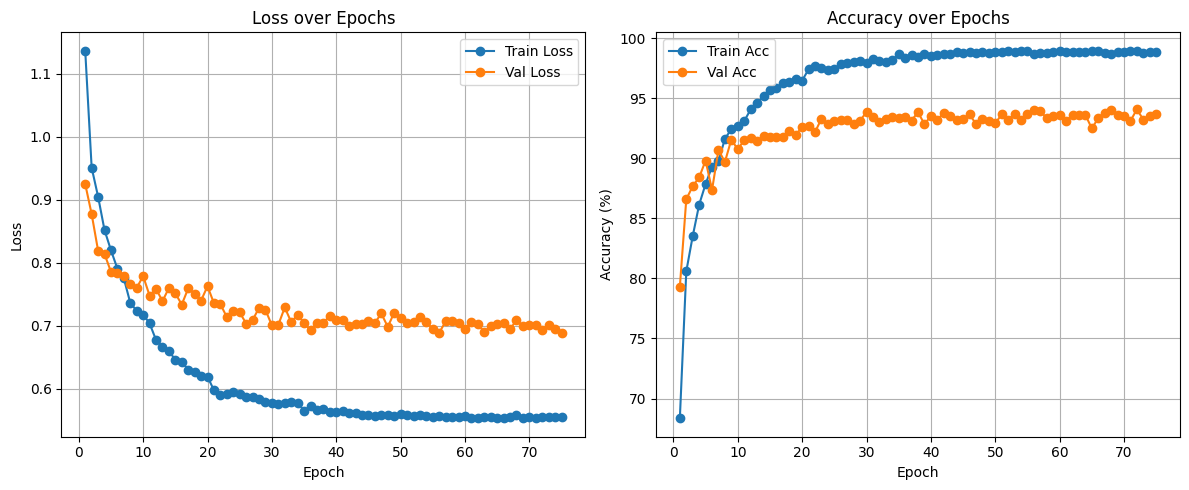

In [4]:
# hyperparameters
num_epochs = 75
learning_rate = 0.001

# loss function
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# optimizer
optimizer = optim.Adam([
   {'params': model.layer3.parameters(), 'lr': 1e-6},
    {'params': model.layer4.parameters(), 'lr': 1e-5},
    {'params': model.fc.parameters(), 'lr': 1e-3}        # higher learning rate for the final layer
])
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")

    # ----- Training -----
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)


    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    
    # ----- Validation -----
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    scheduler.step(val_loss)
   
   
   
    # ------ Plotting ------
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc', marker='o')
plt.plot(epochs, val_accuracies, label='Val Acc', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Test loop

model.eval()
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate average test loss
avg_test_loss = test_loss / len(test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))





Test Loss: 0.7134

Classification Report:
              precision    recall  f1-score   support

           C       0.94      0.98      0.96       363
           M       0.95      0.95      0.95       428
          MN       0.97      0.96      0.97      1000
           R       0.86      0.83      0.85       223
          SK       0.86      0.84      0.85       281
          WM       0.81      0.85      0.83       285

    accuracy                           0.93      2580
   macro avg       0.90      0.90      0.90      2580
weighted avg       0.93      0.93      0.93      2580



C:\Users\sahba\AppData\Local\Temp\ipykernel_23556\3837580526.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_classes)


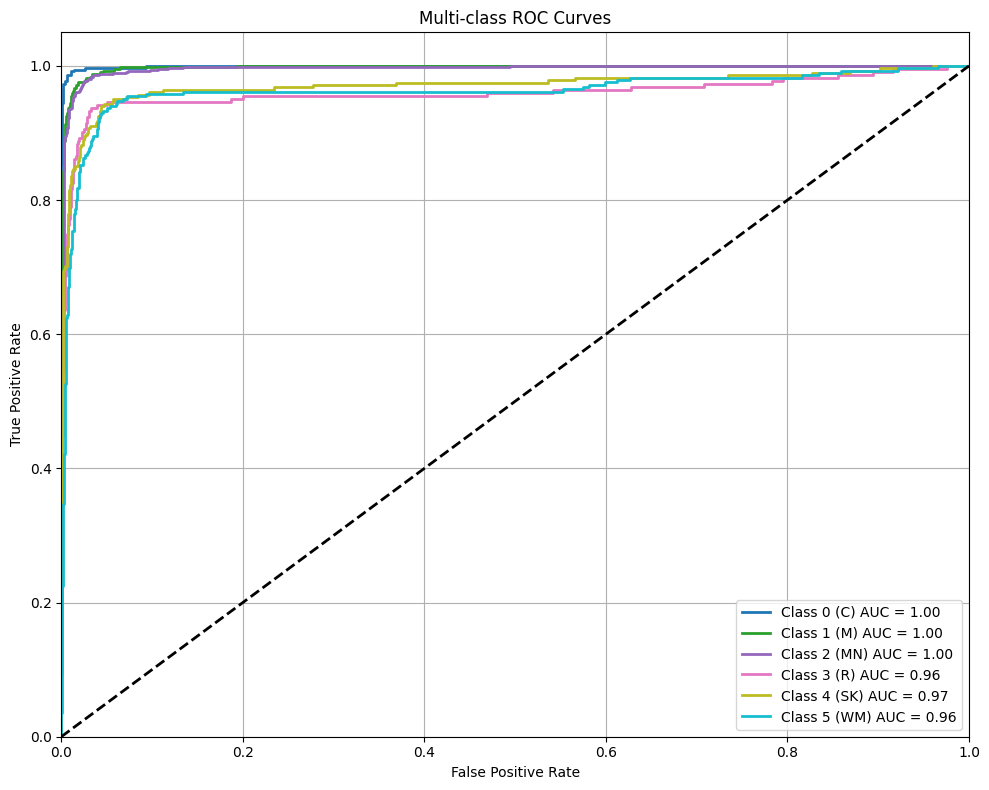

In [ ]:

# ROC and AUC Curve

all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)


from sklearn.preprocessing import label_binarize
all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))  # shape: [n_samples, n_classes]


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plotting
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap("tab10", num_classes)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label=f'Class {i} ({full_dataset.classes[i]}) AUC = {roc_auc[i]:.2f}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


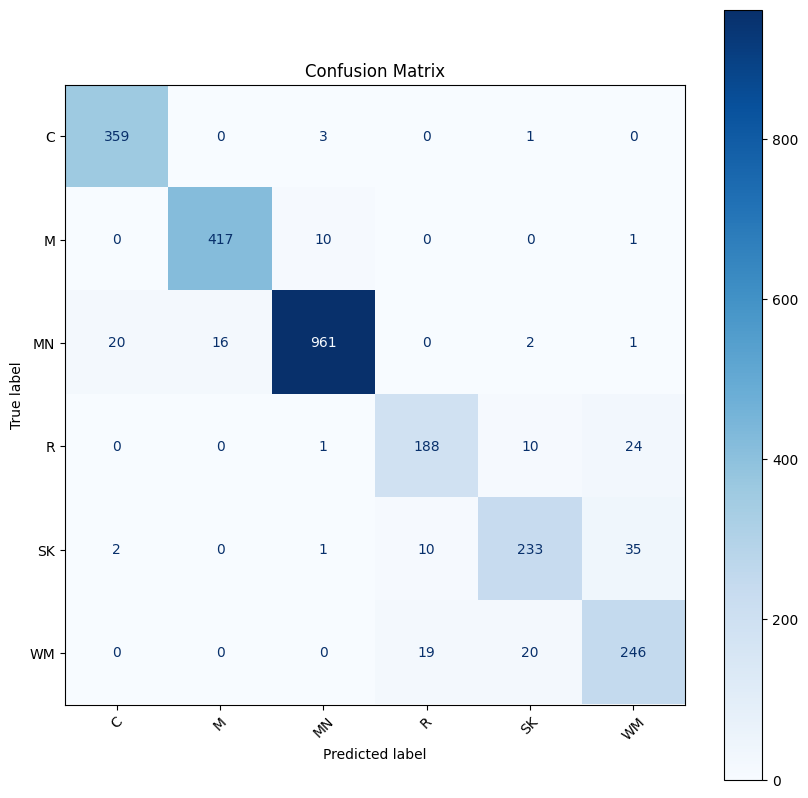

In [ ]:
#Confusion Matrix


all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [ ]:

torch.save(model.state_dict(), "ResNet_50_93%.pth")